# Binaryzacja

### Zadanie domowe - binaryzacja adaptacyjna w oknach z interpolacją.

Pokazana w ramach podstawowej części ćwiczenia binaryzacja adaptacyjna działa dobrze, ale jest dość złożona obliczeniowo (choć oczywiście należy mieć świadomość, że implementację można zoptymalizować i wyeliminować pewne powtarzające się obliczenia).
Zbliżone rozwiązanie można również realizować w nieco innym wariancie - w oknach.
Ogólna idea jest następująca: wejściowy obraz dzielimy na nienachodzące (rozłączne) okna - wygodnie jest założyć, że są one kwadratowe i o rozmiarze będącym potęgą liczby 2.
W każdym z okien obliczamy próg - niech to będzie średnia i stosujemy do binaryzacji lokalnej.
Jak nietrudno się domyślić efekt nie będzie dobry, gdyż na granicach okien wystąpią artefakty.
Aby je wyeliminować należy zastosować interpolację, co zostanie szczegółowo opisane poniżej.
Warto zaznaczyć, że podobny mechanizm interpolacji stosowany jest w poznanym wcześniej algorytmie CLAHE.
Zainteresowane osoby odsyłam do artykułu na [Wikipedii](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) oraz do artykułu o metodzie CLAHE - Zuiderveld, Karel. “Contrast Limited Adaptive Histograph Equalization.” Graphic Gems IV. San Diego: Academic Press Professional, 1994. 474–485.



Na początek zaimplementujemy wariant metody bez interpolacji:
1. Wczytaj obraz _rice.png_.
2. W dwóch pętlach `for`, dla okien o ustalonym wymiarze $W$ (potęga 2), oblicz średnią:
- pętle powinny mieć krok $W$,
- wynik (tj. średnie) należy zapisać w pomocniczej tablicy,
- przydatny operator to `//` - dzielenie całkowitoliczbowe (*floor division*).

3. W kolejnych dwóch pętlach `for` (tym razem o kroku 1) przeprowadź binaryzację z wyznaczonymi progami.
   Tu oczywiście należy się sprytnie odwołać do wyników z tablicy pomocniczej.
   Wyświetl wyniki - czy jest on poprawny?
   Podpowiedź - błędy lepiej widać dla mniejszego rozmiaru okna (np. 16 x 16).

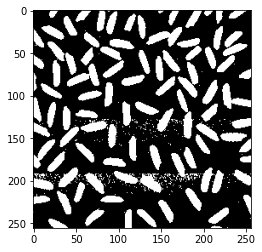

In [47]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def bin_adaptacyjna(img, W):
    X, Y = img.shape
    bin_img = np.zeros(img.shape)

    means= np.zeros((int(X/W)+1,int(Y/W)+1))    

    for i in range(0, int(X/W)+1):
        for j in range(0, int(Y/W)+1):
            img_frame = img[ int(i*W) : int((i+1)*W)  , int(j*W) : int((j+1)*W) ]
            means[i,j]= cv2.mean(img_frame)[0]

    for i in range(0, X):
        for j in range(0, Y):
            if img[i,j] > means[int(i/W), int(j/W)]:
                    bin_img[i,j] = True;
            else:
                    bin_img[i,j] = False;
                
    return bin_img.astype(np.int)


if not os.path.exists("rice.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/rice.png --no-check-certificate
        
image = cv2.imread("rice.png", cv2.IMREAD_GRAYSCALE)
plt.gray()

plt.imshow(bin_adaptacyjna(image,64))
        

4. Rozwiązaniem problemu artefaktów na obrazie jest zastosowanie interpolacji.
   Próg binaryzacji dla danego okna wyliczany jest na podstawie progów z sąsiednich okien.
   ![Ilustracja koncepcji interpolacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/clahe_tile_interpolation.png)

   Koncepcja została przedstawiona na powyższym rysunku.
   Możliwe są 3 przypadki:
   - piksel leży w rogach obrazu (kolor czerwony) - wtedy za próg przyjmuje się wartość średniej obliczonej dla danego okna,
   - piksel leży na krawędzi obrazu (kolor zielony) - wtedy za próg przyjmuje się wartość obliczoną na podstawie średnich z dwóch sąsiednich okien,
   - piksel leży w środku (kolor fioletowy) - wtedy próg jest obliczany na podstawie 4 sąsiednich okien.

   Uwaga. Proszę zwrócić uwagę, że sprawa jest dość złożona.
   Obraz dzielimy na okna (dla nich liczymy średnią) i następnie każde z okien "wirtualnie" na cztery sub-okna (linie przerywane).
   To ułatwia znalezienie środków okien (czarne kwadraty), które są wykorzystywane w interpolacji.

5. Implementujemy interpolację.
   Potrzebujemy do tego znać progi (jeden, dwa lub cztery), ale dla przejrzystości obliczeń lepiej zawsze przyjąć cztery oraz odległości od rozważnego piksela do środka sąsiednich okien (też w ogólnym przypadku 4):
   - całość sprowadza się do określania pozycji piksela,
   - na początek rozważmy przypadek czterech narożników (kolor czerwony na rysunku) - trzeba napisać `if`, który je wyznaczy,
   - warto sprawdzić, czy nie popełniliśmy błędu i np. tymczasowo do obrazu wynikowego w tym miejscu przypisać wartość 255. Efekt powinien być taki, że widoczne będą tylko narożniki.
   - drugi przypadek do brzegi (kolor zielony) - postępujemy podobnie jak przy narożnikach, przy czym osobno wydzielamy brzegi pionowe i poziome. Tu też warto sobie obrazek "pokolorować".
   - na koniec wyznaczamy piksele w środku.
   - analizując poprawność proszę zwrócić uwagę na to, żeby nie było przerw pomiędzy obszarami.
   - mając podział możemy dla każdego z obszarów wyliczyć cztery progi ($t11, t12, t21, t22$):
        - dla narożników wartość ta będzie identyczna i wynosi po prostu `t11 =t[jT][iT]`, gdzie `iT=i//W` oraz `jT=j//W`.
          Uwaga. Proszę używać indeksów tymczasowych $jT,iT$, gdyż będą potrzebne w dalszych obliczeniach.
        - dla brzegów pionowych występują dwie wartości: okno bieżące i sąsiednie.
          Wyznaczenie współrzędnej poziomej jest proste (jak dla narożników).
          Nad współrzędną pionową trzeba się chwilę zastanowić - aby nie rozważać wielu przypadków można od bieżącej współrzędnej odjąć połowę rozmiaru okna i dopiero później wykonać dzielenie przez rozmiar okna.
          W ten sposób otrzymujemy indeks okna o mniejszej współrzędnej.
          Indeks drugiego uzyskamy dodając 1.
          Proszę się zastanowić dlaczego to działa - najlepiej to sobie rozrysować.
        - dla brzegów poziomych należy postąpić analogicznie,
        - obliczenia dla obszaru wewnątrz powinny być już oczywiste.
   - kolejny krok to wyliczenie odległości pomiędzy rozważanym pikselem, a czterema środkami.
     Przykładowo dla osi X wygląda to następująco: `dX1 = i - W/2 - iT*W` oraz `dX2 = (iT+1)*W - i-W/2`.
     Dla osi Y analogicznie.
     Ponownie proszę się zastanowić dlaczego to jest poprawne - najlepiej to sobie narysować.
   - ostatni krok to interpolacja dwuliniowa.
     Wykonamy ją w trzech krokach:
     - interpolacja w osi X dla dwóch górnych okien - sprowadza się ona do średniej ważonej pomiędzy wartościami $t11$ i $t12$, przy czym wagi to odpowiednio $dX2/W$ i $dX1/W$.
       Ponownie na podstawie rysunku proszę to przemyśleć.
     - interpolacja w osi X dla dolnych okien jest analogiczna,
     - interpolacja w osi Y również jest analogiczna, z tym, że wejściem są dwa wyniki interpolacji w poziomie.

6. "Kropka nad i" to oczywiście binaryzacja z wyznaczonym poprzez interpolację progiem - proszę dobrać rozmiar okna.
7. Na koniec proszę porównać na wspólnym rysunku poznane metody binaryzacji:
- Otsu,
- lokalna na podstawie średniej,
- lokalna Sauvoli,
- lokalna w oknach bez interpolacji,
- lokalna w oknach z interpolacją.

Proszę pod porównaniem, w osobnej sekcji *markdown*, krótko skomentować uzyskane wyniki.

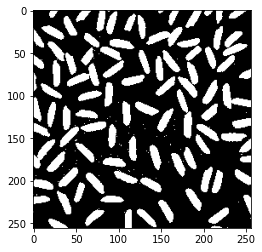

In [36]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os


def bin_adaptacyjna_interpolowana(img, W):
    X, Y = img.shape
    bin_img = np.zeros(img.shape)

    means= np.zeros((int(X/W)+1,int(Y/W)+1))
    t11, t12, t21, t22 = 0, 0, 0, 0

    for i in range(0, int(X/W)+1):
        for j in range(0, int(Y/W)+1):
            img_frame = img[ int(i*W) : int((i+1)*W)  , int(j*W) : int((j+1)*W) ]
            means[i,j]= cv2.mean(img_frame)[0]

    for i in range(0, X):
        for j in range(0, Y):
            iT=i//W
            jT=j//W

            # po odległości dX1 i dY1 w której połówce znajduje się dany piksel:
            #  ----  ---
            # | 1  |  2 |
            #  --- x ---
            # | 3  |  4 |
            #  ---  ---
            # dX1 <=  0 i dY1 <= 0  wtedy podokno 1
            # dX1 <=  0 i dY1 >  0  wtedy podokno 2
            # dX1  >  0 i dY1 <= 0  wtedy podokno 3
            # dX1  >  0 i dY1 >  0  wtedy podokno 4

            # odległość dX1 i dY2 to odległość od środka okna w którym znajduje się dany piksel

            dX1= i - W/2 - iT*W  #odległość w pionie bo od i zależą wiersze
            dY1= j - W/2 - jT*W  #odległość w poziomie bo od j zależą kolumny

            # odległośći dX2 i DY2 zależą odpowiednio od dX1 i DY2
            dX2 = W - abs(dX1)    # odległosci są mierzone bezwglednie aby potem użyć ich do średniej ważonej
            dY2 = W - abs(dY1)    # dX1 i dY2 narazie nie jest bezwględna ponieważ na ich podstwie określa się podookno do jakiego mają trafić

            if (i <= W/2 and j <= W/2 ) or (i > (X - W/2) and j <= W/2) or (i  <= W/2 and j > (Y-W/2)) or (i > (X- W/2) and j > (Y-W/2)) : # sprawdzenie czy PODOKNO nie jest rogiem odpiwednie LT LB RT RB
                avg = means[iT,jT]

            elif (i <= W/2  and j > (W/2)  and (j <= (Y - W/2))) or  (i > (X-W/2)  and j > (W/2)  and (j <= (Y - W/2))): # boki poziome 
                #mamy dwa przypadki czy podokno ze srednią ma być z prawej wziete czy z lewej możemy to stwierdzić po wartości dY1 gdy jest <=0 wtedy bierzemy sąsiada z lewej i odpowiednio dla > 0
                waga_Y1=abs(dY1/W)
                waga_Y2=abs(dY2/W)

                if(dY1 <= 0):
                    avg= np.average([means[iT,jT],means[iT,jT-1]], weights= [waga_Y2, waga_Y1])
                else:
                    avg= np.average([means[iT,jT],means[iT,jT+1]], weights= [waga_Y2, waga_Y1])


            elif (j <= W/2  and i > (W/2)  and (i <= (X - W/2))) or  (j > (Y-W/2)  and i > (W/2)  and (i <= (X - W/2))): # boki pionowe
                #mamy dwa przypadki podobnie jak z poziomymi czy danemu fragmentowi należy pobrać średnia zgórnego sąsiada czy dolnego
                waga_X1=abs(dX1/W)
                waga_X2=abs(dX2/W)

                if(dX1 > 0):
                    avg= np.average([means[iT,jT],means[iT+1,jT]], weights= [waga_X2, waga_X1])
                else:
                    avg= np.average([means[iT,jT],means[iT-1,jT]], weights= [waga_X2, waga_X1])

            else: #środkowe podokna, tutaj już są 4 przypadki w zależności którym jest dane podokno
                waga_X1=abs(dX1/W)
                waga_X2=abs(dX2/W)
                waga_Y1=abs(dY1/W)
                waga_Y2=abs(dY2/W)

                #wejściem do iterpolacji z osi oy tzn po współrzędnej iT są wyniki z interpolacji w osi ox tzn po zmiennej jT
                if dX1 <=  0 and dY1 <= 0:   #wtedy podokno 1
                    avg_ox1 = np.average([means[iT-1,jT],means[iT-1,jT-1]], weights= [waga_Y2, waga_Y1])
                    avg_ox2 = np.average([means[iT,jT],means[iT,jT-1]], weights= [waga_Y2, waga_Y1])
                    avg = np.average([avg_ox1, avg_ox2], weights = [waga_X1, waga_X2])

                elif dX1 <=  0 and dY1 >  0:  #wtedy podokno 2
                    avg_ox1 = np.average([means[iT-1,jT],means[iT-1,jT+1]], weights= [waga_Y2, waga_Y1])
                    avg_ox2 = np.average([means[iT,jT],means[iT,jT+1]], weights= [waga_Y2, waga_Y1])
                    avg = np.average([avg_ox1, avg_ox2], weights = [waga_X1, waga_X2])

                elif dX1 > 0 and dY1 <= 0:  #wtedy podokno 3 
                    avg_ox1 = np.average([means[iT+1,jT],means[iT+1,jT-1]], weights= [waga_Y2, waga_Y1])
                    avg_ox2 = np.average([means[iT,jT],means[iT,jT-1]], weights= [waga_Y2, waga_Y1])
                    avg = np.average([avg_ox1, avg_ox2], weights = [waga_X1, waga_X2])

                elif dX1 > 0 and dY1 >  0:  #wtedy podokno 4 
                    avg_ox1 = np.average([means[iT+1,jT],means[iT+1,jT+1]], weights= [waga_Y2, waga_Y1])
                    avg_ox2 = np.average([means[iT,jT],means[iT,jT+1]], weights= [waga_Y2, waga_Y1])
                    avg = np.average([avg_ox1, avg_ox2], weights = [waga_X1, waga_X2])


            if img[i,j] > avg:
                bin_img[i,j] = True;
            else:
                bin_img[i,j] = False;



    return bin_img.astype(np.int)



if not os.path.exists("rice.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/04_Thresholding/rice.png --no-check-certificate
        
image = cv2.imread("rice.png", cv2.IMREAD_GRAYSCALE)
plt.gray()

plt.imshow(bin_adaptacyjna_interpolowana(image, 64))


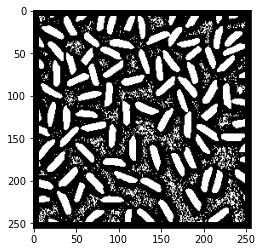

In [39]:
#OSTU
def otsu(image):
    dst = np.zeros(image.shape)

    image_normalized=cv2.normalize(image,dst,0,255,cv2.NORM_MINMAX)
    image_hist = cv2.calcHist([image_normalized],[0],None,[256],[0,256])
    image_hist_cumsum = image_hist.cumsum()

    image_hist=np.squeeze(image_hist)

    k = int(cv2.mean(image)[0])

    sigma_bp=0
    thresh= -1

    rang = np.arange(256)


    for k in range(0,255):
        P_0=image_hist_cumsum[int(k)] / image_hist_cumsum.max()
        P_1= 1 - P_0

        P_0_sum = 0
        for i in range(0, int(k)+1):
            P_0_sum = P_0_sum + i * image_hist[i] / image_hist_cumsum.max()

        m_0=P_0_sum / P_0

        P_1_sum = 0
        for i in range(int(k)+1, len(image_hist)):
            P_1_sum = P_1_sum + i * image_hist[i] / image_hist_cumsum.max()

        m_1=P_1_sum / P_1

        sigma_b=P_0*P_1*((m_0-m_1)**2)

        if sigma_b > sigma_bp:
            sigma_bp = sigma_b
            thresh = k
    
    
    bin_image = image_normalized > thresh
    return bin_image.astype(np.int)


# binaryzacja lokalna na podstawie średniej
def bin_lokalna_sr(img, frame):
    X, Y = img.shape
    bin_img = np.zeros(img.shape)
    
    for i in range(int(frame/2), X - int(frame/2)):
        for j in range(int(frame/2), Y - int(frame/2)):
            mean = cv2.mean(img[ int(i - (frame/2)) : int(i + (frame/2)) , int(j - (frame/2)) : int(j + (frame/2)) ])[0] 
            #print(mean)
            if img[i,j] > mean:
                bin_img[i,j] = True;
            else:
                bin_img[i,j] = False;
                
    return bin_img.astype(np.int)



# binaryzacja Savouli
def bin_sauvoli(img, frame, factor):
    R = 128
    k = 0.15
    X, Y = img.shape
    bin_img = np.zeros(img.shape)
    
    for i in range(int(frame/2), X - int(frame/2)):
        for j in range(int(frame/2), Y - int(frame/2)):
            img_frame = img[ int(i - (frame/2)) : int(i + (frame/2)) , int(j - (frame/2)) : int(j + (frame/2)) ]
            mean = cv2.mean(img_frame)[0]
            std = np.std(img_frame)
            
            threshold = mean * ( 1 + factor * k * (std/R -1))
            #print(mean)
            if img[i,j] > threshold:
                bin_img[i,j] = True;
            else:
                bin_img[i,j] = False;
                
    return bin_img.astype(np.int)





(-0.5, 255.5, 255.5, -0.5)

<Figure size 432x288 with 0 Axes>

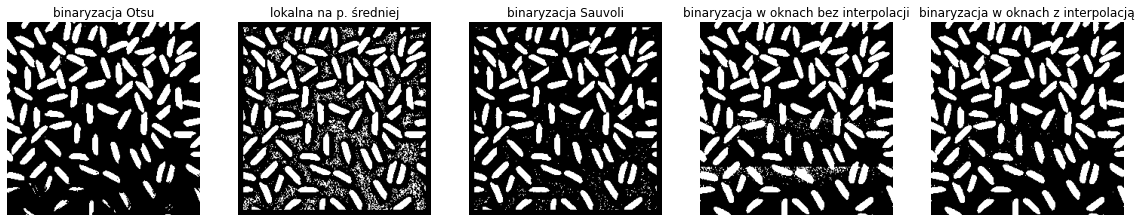

In [45]:
#porowanie binaryzacji
image = cv2.imread("rice.png", cv2.IMREAD_GRAYSCALE)
plt.gray()

fig1, (p1, p2, p3, p4, p5) = plt.subplots(1,5,figsize=(20,20))

p1.imshow(otsu(image))
p1.title.set_text("binaryzacja Otsu")
p1.axis('off')

p2.imshow(bin_lokalna_sr(image,15))
p2.title.set_text("lokalna na p. średniej")
p2.axis('off')

p3.imshow(bin_sauvoli(image,15,(-1)))
p3.title.set_text("binaryzacja Sauvoli")
p3.axis('off')

p4.imshow(bin_adaptacyjna(image,64))
p4.title.set_text("binaryzacja w oknach bez interpolacji")
p4.axis('off')

p5.imshow(bin_adaptacyjna_interpolowana(image,64))
p5.title.set_text("binaryzacja w oknach z interpolacją")
p5.axis('off')

In [ ]:
# Porównując wszystkie otrzymane wyniki, każda z binaryzacji jest nieco inna:

# - Binaryzacja metodą Otsu dała najbardziej kontrastowy wynik praktycznie bez żadnego szumu natomiast zgubiła niektóre "ryże".

# - Binaryzacja lokalna na podstawie średniej dała obraz o wiele bardzie zaszumiony, aczkolwiek w porównaniu z otsu nie zgubiła niektórych obiektów.

# - Binaryzacja Sauvoli można powiedzieć pozbyła się błędów binaryzacji na podstawie średniej (szumów między ziarenkami) nadal otrzymując obraz z wszystkimi obiektami, jednak niektóre zaszumienia nadal pozostały. 

# - Binaryzacja w oknach bez interpolacji można powiedzieć że dała, podobny wynik co binaryzacja Sauvoli, obraz jest dobry ale nie pozbawiony wad. Dodatkowo niestet na niekorzyść jej pojawiają się artefakty,
#     szczególnie widoczne przy obrazach w których średnia między oknami się bardzo różni.

# - Binaryzacja w oknach z iterpolacja moim zdaniem dała najlepszy rezultat zachowała wszystkie obiekty, a także posiada najmniejsze zaszumienie (nie licząc otsu), dzięki zasłudze interpolacji nie występują artefakty
